# title of the project 
## a list of author(s) names,


## Abstract
a few short sentences highlighting the main points of the project

## Introduction
(3-4 paragraphs) reviewing your topic, related technical ideas/algorithms, your selected methodology/approach, its motivation, and outlining the overall structure/organization of the report. 


## Contributions

## Methods
### 1. Estimate the radiometric response function from the aligned images

Estimate irradiance values $E_i$ and the radiometric response function $f$ at the same time. 

$$z_{ij} = f(E_it_j)$$ where $t_j$ is the exposure time for the $j$th image. 

The inverse response curve $f^{−1}$ is given by
$$f^{−1}(z_{ij}) = E_i t_j$$

Taking logarithms of both sides 
$$g(z_{ij})=\log f^{-1}(z_{ij})=\log E_i +\log t_j$$
 ($g$ maps pixel values $z_{ij}$ into log irradiance)
 


Also, we need make the reponse curve smooth by adding a second-order smoothness constraint
$$\lambda\sum_k g''(k)^2 = \lambda\sum[g(k-1) - 2g(k)+ g(k+1)]^2$$

Since pixel values are more reliable in the middile of their range, they also add a weight function
$$ w(z)=\left\{
\begin{aligned}
z-z_{min} & &  z \le (z_{min}+z_{max})/2 \\
z_{max}-z & & z \gt (z_{min}+z_{max})/2 \\
\end{aligned}
\right.
$$

Put all together we get a least squares problem to estimate the radiometric response function $g$ and irradiance values $E_i$

$$E = \sum_i\sum_jw(z_{i,j})[g(z_{i,j}) - \log E_i - \log t_j]^2 + \lambda\sum_k g''(k)^2$$

In other word, we are solve the two equations 
$$ w(z_{i,j}) g(z_{i,j}) - w(z_{i,j}) \log E_i  = w(z_{i,j}) \log t_j $$ 
$$\lambda[g(z_{i,j}-1) - 2g(z_{i,j})+ g(z_{i,j}+1)] = 0$$
together


#### Assume that $t_j$ is known

The response value $g_k = g(k)$, where g can be discretized according to the 256 pixel values commonly observed in eight-bit images. (The response curves are calibrated separately for each color channel.)

In [2]:
import numpy as np
from PIL import Image
import matplotlib.image as image
import matplotlib.pyplot as plt

(578, 870, 3)


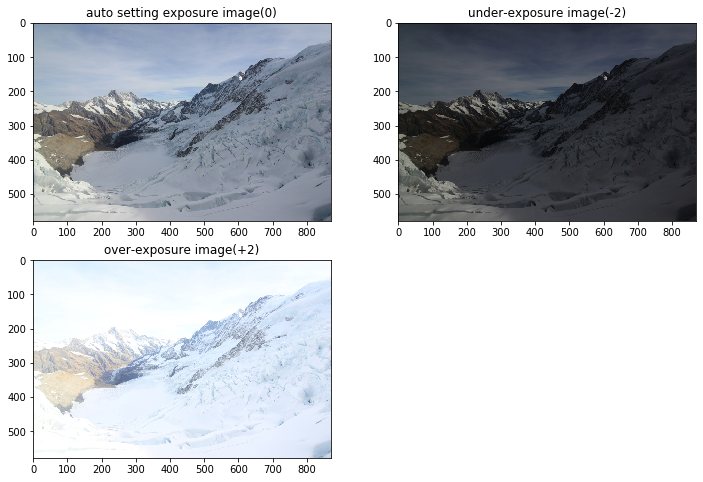

In [3]:
# load some toy data to play with 
# source: https://www.easyhdr.com/examples/mountains
im_auto_expose = image.imread("hdr-mountain/mountains_0.jpg")
im_under_expose = image.imread("hdr-mountain/mountains_-2.jpg")
im_over_expose = image.imread("hdr-mountain/mountains_+2.jpg")

# plot 
print(im_auto_expose.shape)
plt.figure(2,figsize = (12, 8))
plt.subplot(221)
plt.imshow(im_auto_expose)
plt.title("auto setting exposure image(0)")
plt.subplot(222)
plt.imshow(im_under_expose)
plt.title("under-exposure image(-2)")
plt.subplot(223)
plt.imshow(im_over_expose)
plt.title("over-exposure image(+2)")
plt.show()



In [4]:
'''
Modified from gsolve.m

Solve for imaging system response function

Given a set of pixel values observed for several pixels in several
images with different exposure times, this function returns the
imaging system’s response function


Z(i,j): the pixel values of pixel location number i in image j

B(j): the log delta t, or log shutter speed, for image j

l: lamdba, the constant that determines the amount of smoothness

w(z): the weighting function value for pixel value z

'''
zmin = 0.
zmax = 255.

def weight_hat(z):
    return min(z-zmin, zmax-z)

def gsolve(Z, B, lmd, w=weight_hat):

    locations = Z.shape[0]
    sequences = Z.shape[1]
    n = 256  # [0, 255]
    A = np.zeros((locations * sequences + n - 1, locations + n), dtype=float)
    b = np.zeros(A.shape[0], dtype=float)

    #  Include the data−fitting equations
    k = 0
    for i in range(locations):
        for j in range(sequences):
            wij = w(Z[i, j])
            A[k, int(Z[i, j])] = wij
            A[k, n + i] = -wij
            b[k] = wij * B[j]
            k += 1

    # Fix the curve by setting its middle value to 0, i.e. g(128) = 0    
    A[k, 128] = 1   
    k += 1

    # Include the smoothness equations
    for i in range(n-2):
        wi = w(i)
        A[k, i] = lmd * wi
        A[k, i+1] = -2 * lmd * wi
        A[k, i+2] = lmd * wi
        k += 1

    # Solve the system
    x, _, _, _ = np.linalg.lstsq(A, b)
    g = x[:n]
    lnE = x[n:]

    return (g, lnE)

In [5]:
# test block 
# delete later !!!!

imagebracket = np.array([im_under_expose,im_auto_expose,im_over_expose])
print(imagebracket[0].shape)
# for i in range(3):
#     print(i)
print(np.ndarray.flatten(imagebracket[2][:,:,0]))


(578, 870, 3)
[223 223 223 ... 200 201 198]


In [6]:
# imagepack is to flat each input RGB image into a vector for each channle and pack them into three 2d array
# input: np-array
# return three Z(i,j)(see above) for each channel 
def imagepack(imagearray):
    num_image = imagearray.shape[0]
    # imagesize refer to 1-d image size
    imagesize = imagearray[0].shape[0]*imagearray[0].shape[1]
    Rimagepack = np.zeros((imagesize,num_image))
    Gimagepack = np.zeros((imagesize,num_image))
    Bimagepack = np.zeros((imagesize,num_image))
    # naive loop ; can be optimized later
    for i in range(num_image):
        Rimagepack[:,i] = np.ndarray.flatten(imagearray[i][:,:,0])
        Gimagepack[:,i] = np.ndarray.flatten(imagearray[i][:,:,1])
        Bimagepack[:,i] = np.ndarray.flatten(imagearray[i][:,:,2])
    return (Rimagepack,Gimagepack,Bimagepack)
    

In [7]:
# test block
# delete this later !!!!!!!!
RP,GP,BP = imagepack(imagebracket)
print(RP.shape) 

(502860, 3)


(Note: we need to call $gsolve$ 3 times for R,G,B)

#### Sample

It is in the end of debevec paper

Question: how do we sample the pixel value $z_{ij}$? What is the sample ratio?

For $N$ pixels 

- random select k pixels for each pixel value ([0,255])?

- sample based per grid? (i.e. img[::k, ::k, 0])?

Something to consider: $I$: the number of pixels in an image, $J$: the number of images. We have $I + 256$ unknowns, $IJ + 255$ equations

$\textbf{Technical Discuss: Weakness/Strength Of Difference Sample Methods}$


For randomSample method - pick pixel randomly

- Weakness: not stable - some random result will lead to very bad estimate, for example, only sampling pixels with intensity 10

- Strength: very quick and if our sample size is big enough, the result will be representative


For windowSample method - pick pixel randomly:

- Weakness: not so stable and having no idea how intensity distributes among the whole images. In some extreme case, it may fail to sample some pixel with certain intensity. Also, as Debevec and Malik 1997 indicated we better avoid highly-variance areas, this schema may visit those bad areas

- Strength: very quick and it also goes through the whole images and in some way, it will be representative. 

For pixelCoverSample method - random select k pixels for each pixel value ([0,255])

- Weakness: slow and have to go through the whole image to know the capacity of the k. Also it require shuffle/couting schema to do randomly sample. Fataly sometimes this schema does not work if any intensity is missing

- Strength: all different intensity pixels get reported. Much more representative









In [48]:
'''
Some Sample function here
'''

# sample function
# general template:
# inputimg: np.array - like Z(i,j)(see above) ; parameters for different sampling schemas
# output: sampled input


# random chose "outputsize" pixels
def randomSample(inputimg,outputsize):
    outputsize = int(outputsize)
    indexrange = inputimg.shape[0]
    num_image = inputimg.shape[1]
    output = np.zeros((outputsize,num_image))
    sampleindex = np.random.choice(indexrange,size=outputsize,replace=False)
    for i in range(num_image):
        output[:,i] = inputimg[sampleindex,i]
    return output


# choose pixels per windowsize where windowsize = floor(num of pixel / outputsize)
def windowSample(inputimg,outputsize):
    outputsize = int(outputsize)
    indexrange = inputimg.shape[0]
    num_image = inputimg.shape[1]
    windowsize = int(indexrange/outputsize)
    output = np.zeros((outputsize,num_image))
    sampleindex = np.arange(outputsize) * windowsize
    for i in range(num_image):
        output[:,i] = inputimg[sampleindex,i]
    return output

######## warning: 
######## pixelCoverSample is not so good since sometimes, some certain intensity value will be absent
######## for exmaple, int the toy image, we don't have 0 
######## might try some more tolerant sampling schema

# random select k pixels for each pixel value ([0,255])
# base: using which image as a standard to pick index
# if k is too larger, the output will base on the maxmum possible k value
def pixelCoverSample(inputimg,k,base = 1):
    indexrange = inputimg.shape[0]
    num_image = inputimg.shape[1]
    baseimg = inputimg[:,base]
    print(baseimg)
    pixelrange = 256
    # i copy the inputimg since i will call shuffle later, shuffle is a in-place function
    imgcopy = np.copy(inputimg)
    
    # check whether input k is feasible
    freqcount = np.zeros(pixelrange)
    for i in range(indexrange):
        freqcount[int(baseimg[i])] = freqcount[int(baseimg[i])] + 1
    maxk = np.amin(freqcount)
    kval = k if maxk >= k else maxk
    if kval != k:
        print("warning: the given k is more than the capacity!")
    if kval == 0:
        print("warning: the capacity is zero")
        return
    # sample part:
    # i used an inelegant method ; can improve later
    # better idea - store some info while check whther k is feasible
    # Or we can use some buind-in liabary - I did not find yet

    output = np.zeros((kval * pixelrange,num_image))
    # shuffle the imgs so that we have a random behavior
    np.apply_along_axis(np.random.shuffle,1,imgcopy)
    coutmap = np.full((pixelrange*kval),kval)
    # i is the index of imgcopy
    # j is the number of elements we already have in output
    i = 0
    j = 0
    while True:
        if j == pixelrange*kval:
            break
        else:
            tempval = imgcopy[i]
            if coutmap[int(tempval[base])] != 0:
                output[j,:] = imgcopy[i,:]
                coutmap[int(tempval[base])] = coutmap[int(tempval[base])] - 1
                j = j + 1
            i = i + 1
    return output


$\textbf{Extension: variance-driven sampling}$

$\textbf{Ideal:}$ 

Debevec and Malik 1997 indicated "Furthermore, the pixels are best sampled from regions of the image with low intensity variance so that radiance can be assumed to be constant across the area of the pixel, and the effect of optical blur of the imaging system is minimized"

In this, we can introduce a biased sample schema that the probablity P of each point $X_{ij}$ get sampled is based on its local gradient


$$W_{i,j} = 1 - sigmoid(||\nabla X_{ij}||)$$

$$p(X_{ij}) = \frac{W_{ij}}{\sum_{p,q}W_{p,q}}$$

In [81]:
# we use sigmoid-like function to map our gradient into probality
# subjective to change
# maybe slow due to floating number
def decreaseSigmoid(a):
    return 1 - 1/(1 + np.exp(-1*a))

vfunc = np.vectorize(decreaseSigmoid)

x = np.matrix( [[1,2],[2,3]])
y = vfunc(x)
print(y)
y = np.sum(y)
print(y)

[[0.26894142 0.11920292]
 [0.11920292 0.04742587]]
0.5547731385917971


In [85]:
# input:
# imgpack: data from imagePace
# base: choose which image as basis to caculate local variance
# shape: orignal shape
# output:
# 1-d array - the gradient of the image 
def GradientMap(imgpack,shape,base=1):
    baseimg = imgpack[:,base]
    baseimg = baseimg.reshape(shape)
    yGadient = np.gradient(baseimg,axis =0)
    xGadient = np.gradient(baseimg,axis =1)
    result = np.sqrt(yGadient*yGadient + xGadient*xGadient)
    return result

# input: 
# Gradient:data from GradientMap
# functionvector: function vector applying to each pixel in the image; see numpy.vectorize
# output: 
# the weight map for each pixel
def ProbMap(Gradient, functionvector):
    result = functionvector(Gradient)
    result = result / np.sum(result)
    return result


<IPython.core.display.Javascript object>


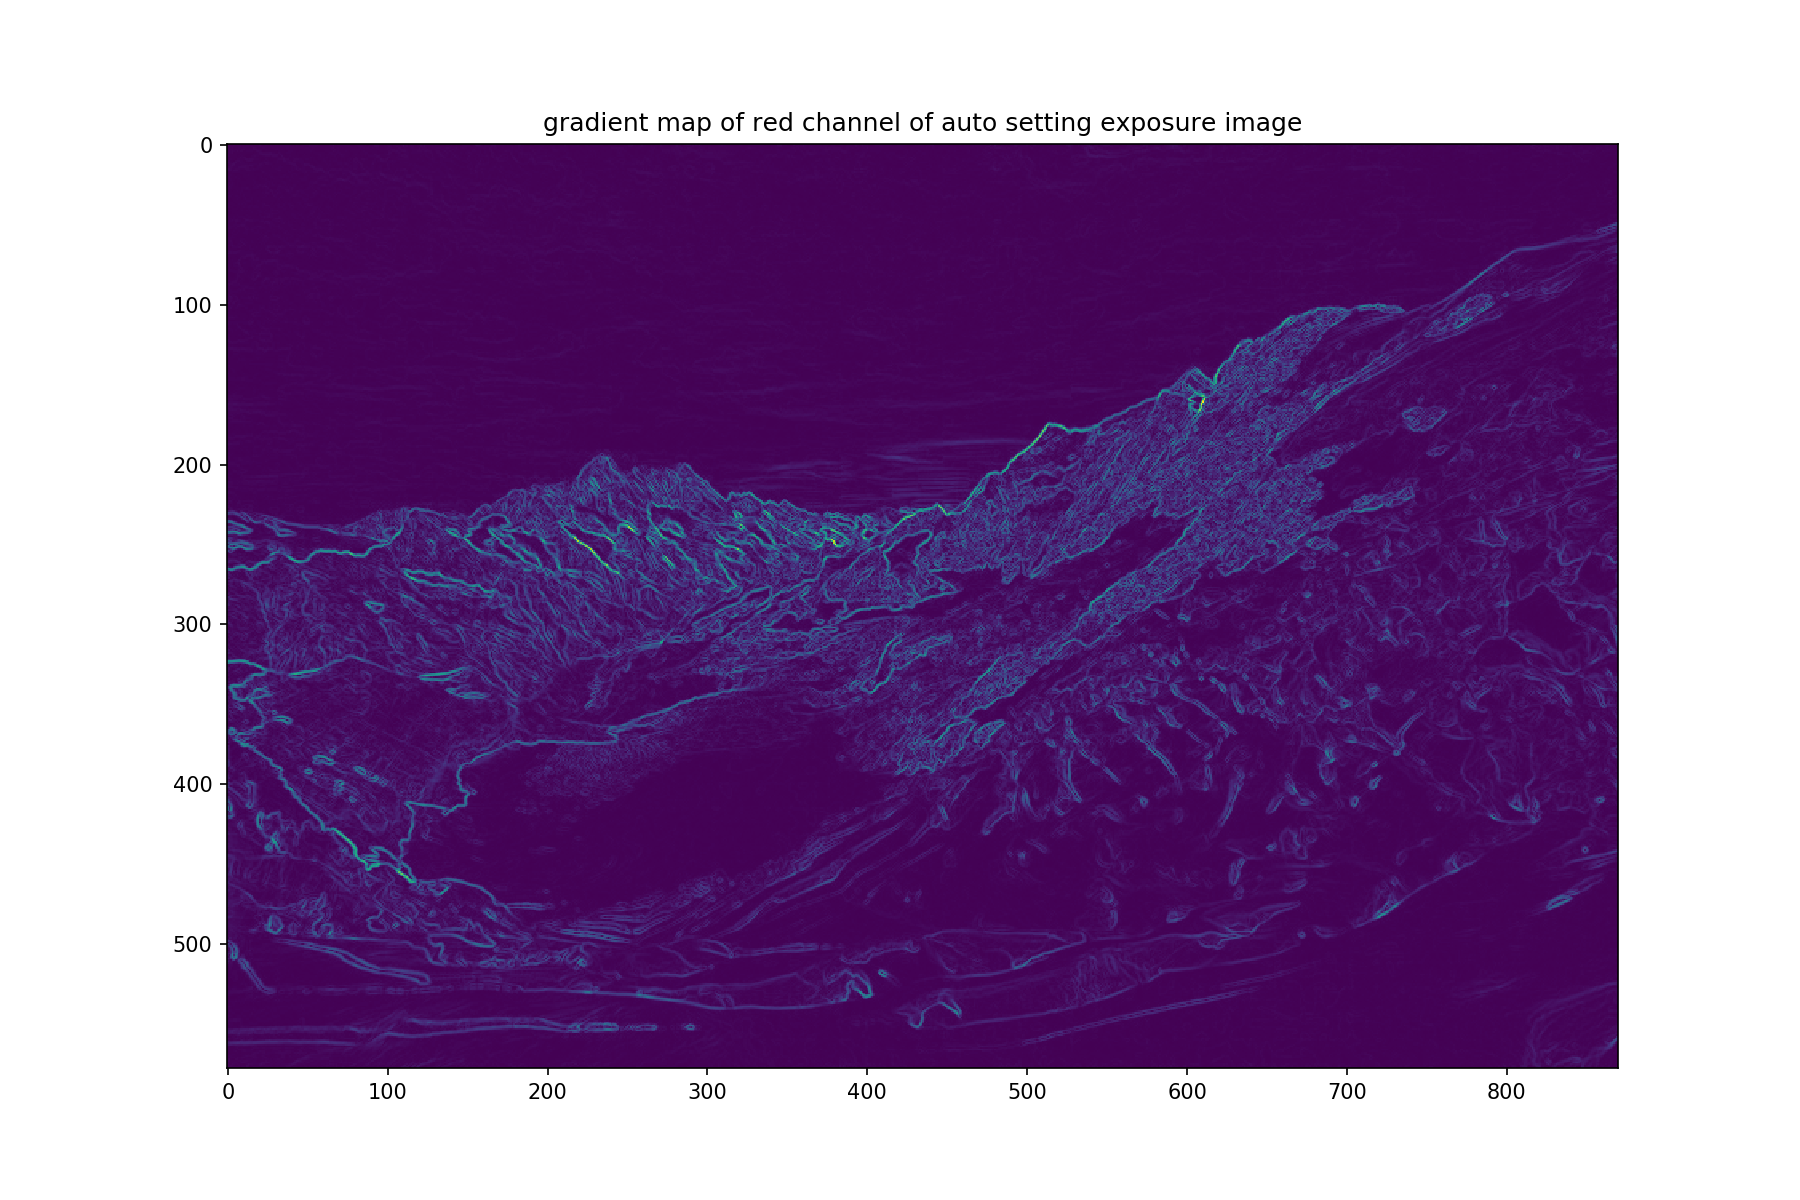

In [88]:
# test block - visualize result 
GradientResult = GradientMap(RP,(im_auto_expose.shape[0],im_auto_expose.shape[1]))

plt.figure(2,figsize = (12, 8))
plt.title("gradient map of red channel of auto setting exposure image")
plt.imshow(GradientResult)


<IPython.core.display.Javascript object>


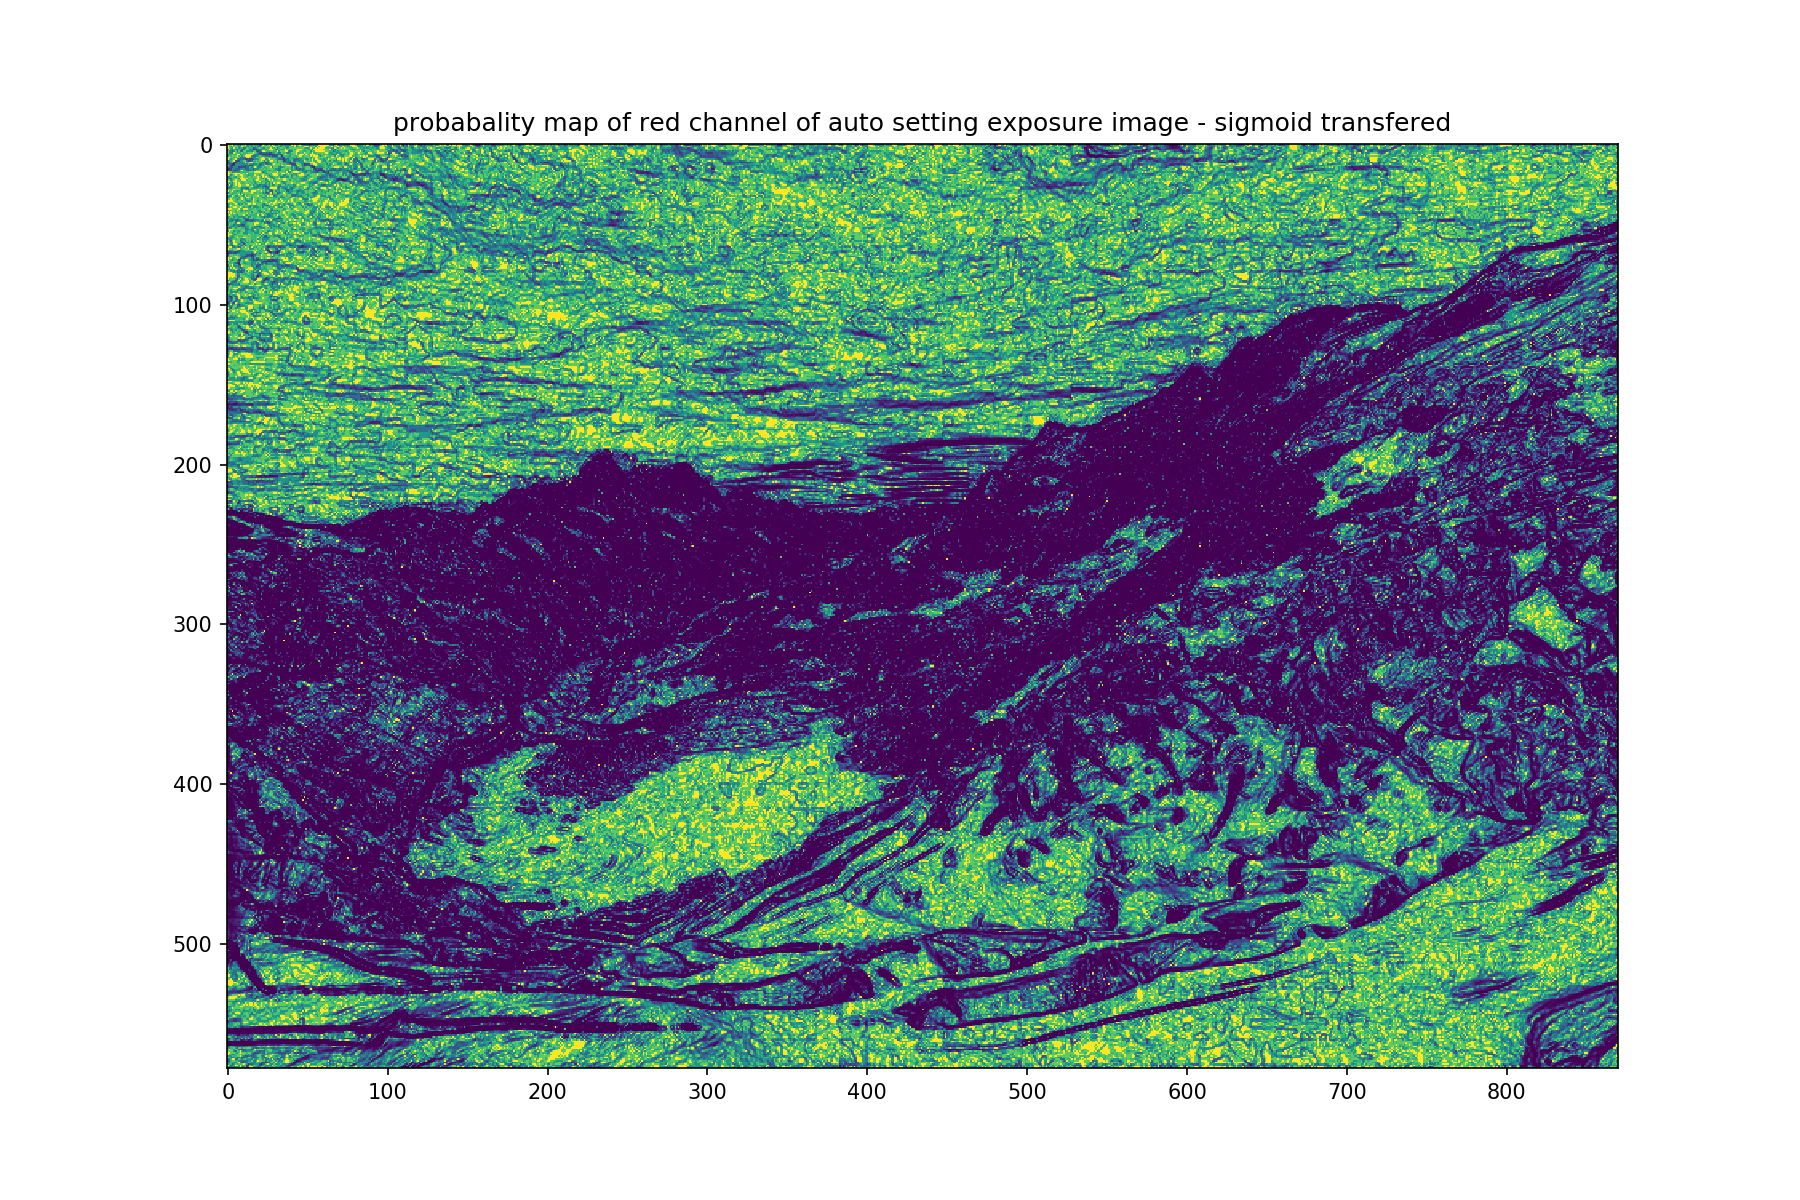

In [92]:
# visualize result 
promap = ProbMap(GradientResult,vfunc)
plt.figure(3,figsize = (12, 8))
plt.title("probabality map of red channel of auto setting exposure image - sigmoid transfered")
plt.imshow(promap)

In [101]:
#### sampling block
# input:
# imgPack: data from imagePack
# probmap: data from ProbMap
# ouputsize: size of the sample 
# output:
# sampled imagePack
def gradientDrivenSample(imgPack,probmap,outputsize):
    pvector = np.ndarray.flatten(probmap)
    outputsize = int(outputsize)
    indexrange = imgPack.shape[0]
    num_image = imgPack.shape[1]
    output = np.zeros((outputsize,num_image))
    sampleindex = np.random.choice(indexrange,size=outputsize,replace=False,p=pvector)
    for i in range(num_image):
        output[:,i] = imgPack[sampleindex,i]
    return output


    

### Print the log response function and result image

Once we have the sample ($z$) and reponse function $g$, we could use it to print figure like 10.13

If the images are noise free, we can use any non-saturated pixel value to estimate the corresponding radiance by mapping it through the inverse response curve $E = g(z)$.

Debevec and Malik (1997) use a hat function (10.7) which accentuates mid-tone pixels while avoiding saturated values.

# Question: How do we choose $\lambda$

In [18]:
%%time
%matplotlib notebook
#### we use window sample here
#### notice this can be very slow
targetsize = (im_auto_expose.shape[1] * im_auto_expose.shape[0]) / 100
sampledRP = windowSample(RP,targetsize)
sampledGP = windowSample(GP,targetsize)
sampledBP = windowSample(BP,targetsize)
Rg, RinE = gsolve(sampledRP,[-2,0,2],0.1)
Gg, GinE = gsolve(sampledGP,[-2,0,2],0.1)
Bg, BinE = gsolve(sampledBP,[-2,0,2],0.1)


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


CPU times: user 4min 28s, sys: 2.55 s, total: 4min 31s
Wall time: 2min 20s


In [104]:
%%time
%matplotlib notebook
#### use gradient drive sample schema here

RPpromap = ProbMap(GradientMap(RP,(im_auto_expose.shape[0],im_auto_expose.shape[1])),vfunc)
GPpromap = ProbMap(GradientMap(GP,(im_auto_expose.shape[0],im_auto_expose.shape[1])),vfunc)
BPpromap = ProbMap(GradientMap(BP,(im_auto_expose.shape[0],im_auto_expose.shape[1])),vfunc)


vDsampledRP = gradientDrivenSample(RP,RPpromap,targetsize)
vDsampledGP = gradientDrivenSample(GP,GPpromap,targetsize)
vDsampledBP = gradientDrivenSample(BP,BPpromap,targetsize)

CPU times: user 3.33 s, sys: 73.9 ms, total: 3.4 s
Wall time: 3.16 s


In [105]:
%%time
%matplotlib notebook
#### we use radient drive sample here
#### notice this can be very slow
vDRg, vDRinE = gsolve(vDsampledRP,[-2,0,2],0.1)
vDGg, vDGinE = gsolve(vDsampledGP,[-2,0,2],0.1)
vDBg, vDBinE = gsolve(vDsampledBP,[-2,0,2],0.1)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


CPU times: user 4min 38s, sys: 3.16 s, total: 4min 42s
Wall time: 2min 30s


<IPython.core.display.Javascript object>


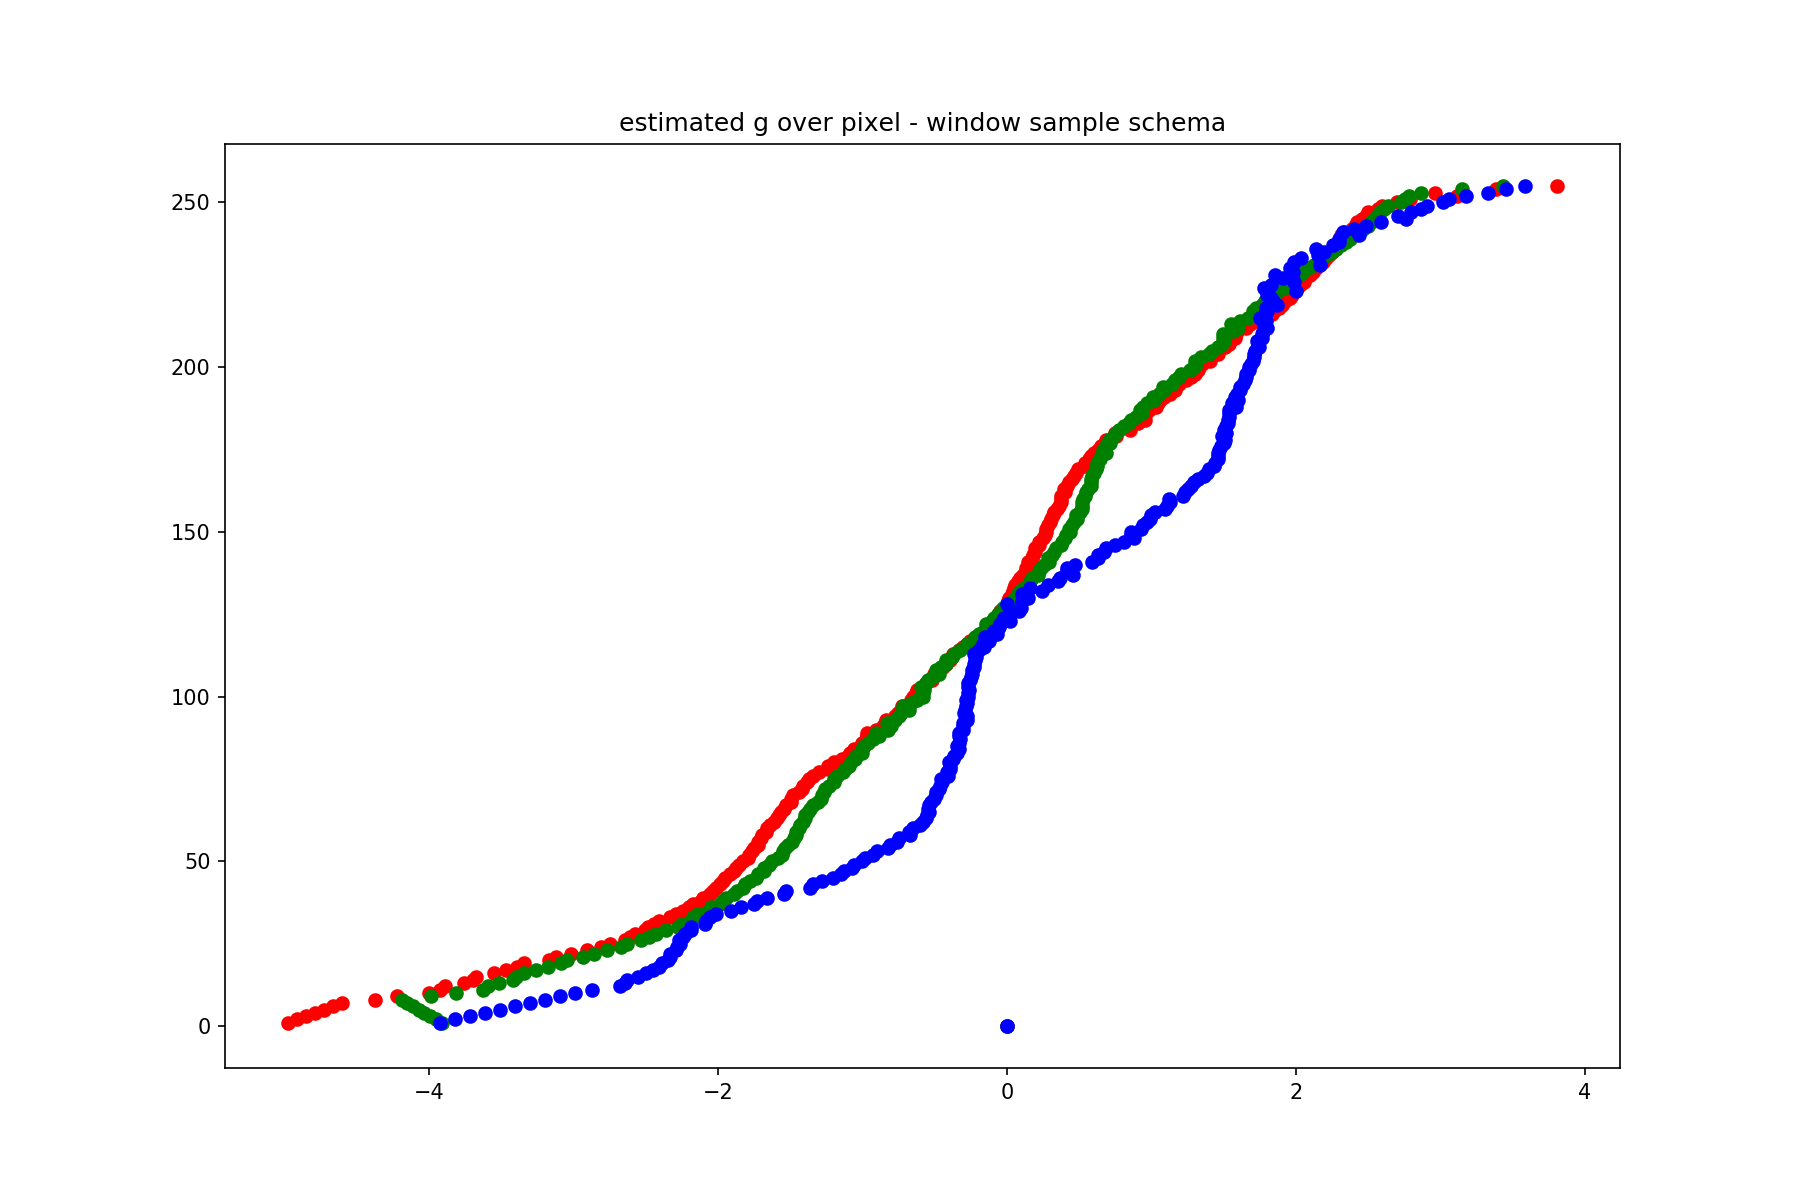

Text(0.5, 1.0, 'estimated g over pixel - window sample schema')

In [106]:
### plot block 
pixelrange = np.arange(256)
plt.figure(4,figsize = (12, 8))
plt.plot(Rg, pixelrange, 'o', color='red')
plt.plot(Gg, pixelrange, 'o', color='green')
plt.plot(Bg, pixelrange, 'o', color='blue')
plt.title("estimated g over pixel - window sample schema")


<IPython.core.display.Javascript object>


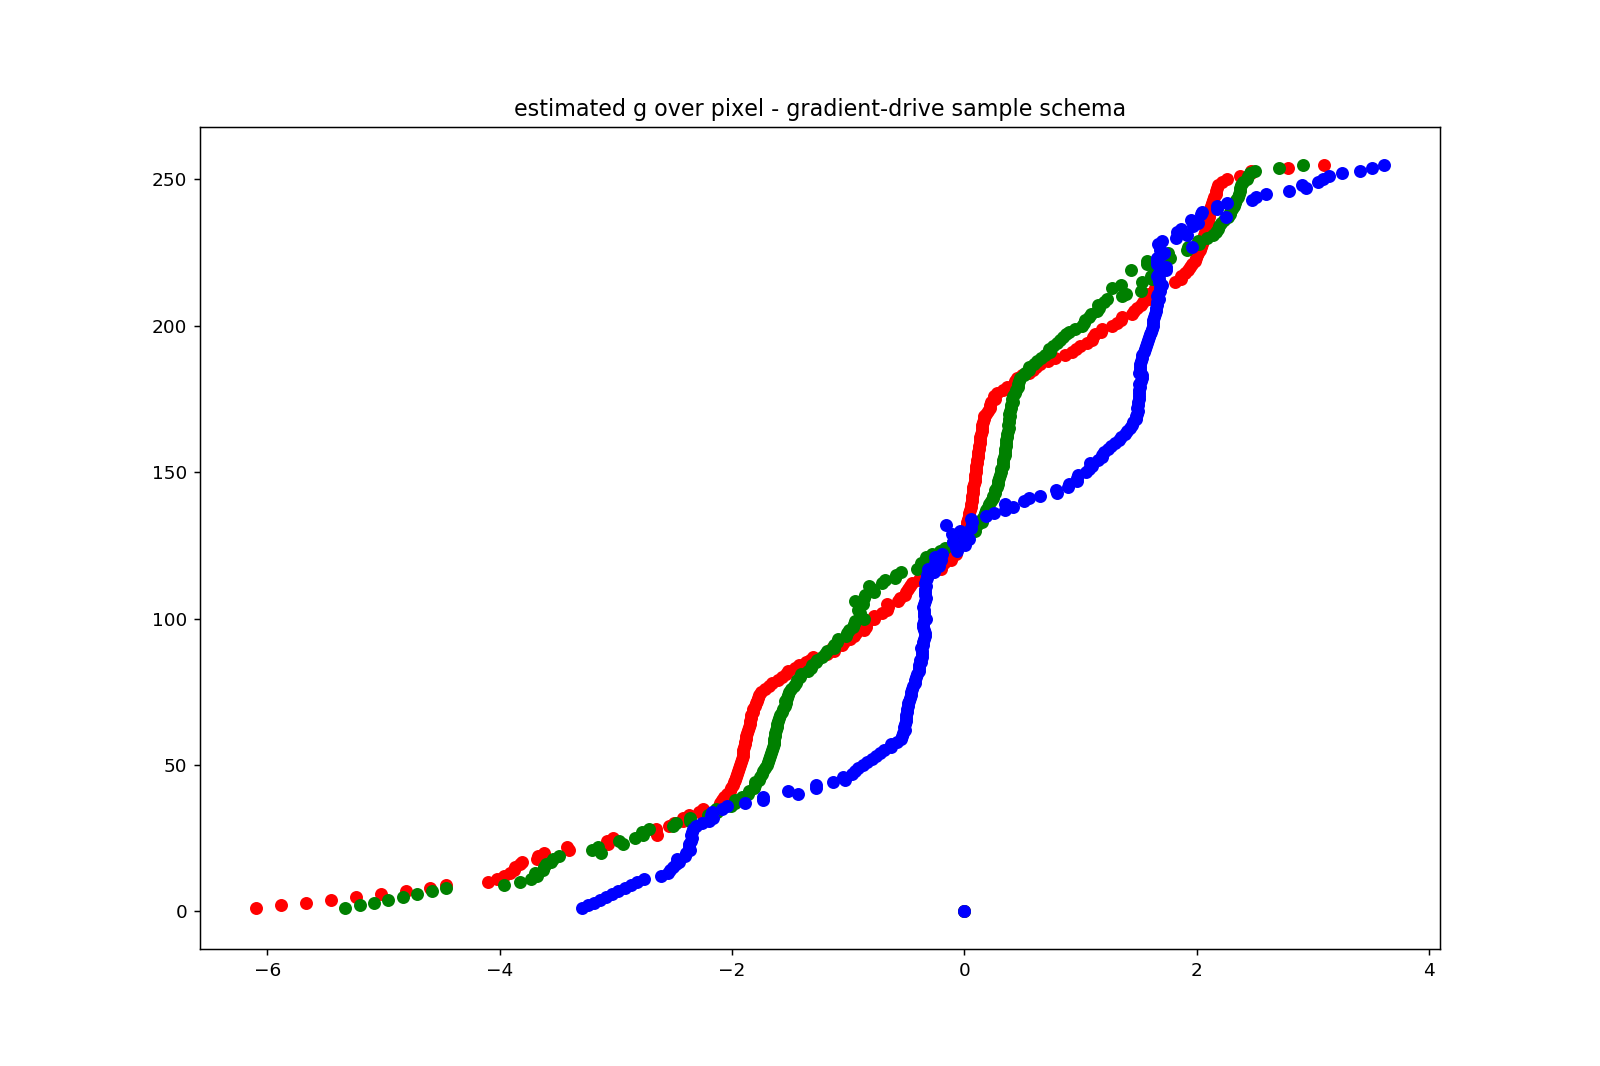

Text(0.5, 1.0, 'estimated g over pixel - gradient-drive sample schema')

In [108]:
pixelrange = np.arange(256)
plt.figure(5,figsize = (12, 8))
plt.plot(vDRg, pixelrange, 'o', color='red')
plt.plot(vDGg, pixelrange, 'o', color='green')
plt.plot(vDBg, pixelrange, 'o', color='blue')
plt.title("estimated g over pixel - gradient-drive sample schema")

In [ ]:
#print(sampledRP.size)
plt.figure(6,figsize=(14,8))
plt.plot(lnE, sampledRP[:,0], 'x', color = 'r')
plt.plot(lnE, sampledRP[:,1], 'x', color = 'g')
plt.plot(lnE, sampledRP[:,2], 'x', color = 'b')

In [ ]:
plt.plot(x, np.arange(256), 'x', color = 'r')

### 2. Estimate a radiance map by selecting of blending pixels from different exposures

(Copy from the book directlt lol, need to be reformated later)

Unfortunately, pixels are noisy, especially under low-light conditions when fewer photons arrive at the sensor. 

Mitsunaga and Nayar (1999) show that in order to maximize the signal-to-noise ratio (SNR), the weighting function must emphasize both higher pixel values and larger gradients in the transfer function
$$
w(z)=g(z)/g'(z)
$$


the weights $w$ are used to form the final irradiance estimate

$$
\log E_i = \frac{\sum_j w(z_{ij})[g(z_{ij})-\log t_j]}{\sum_j w(z_{ij})}
$$

In [109]:
g = np.array([1,2])
b = np.array([3,4])
print(g/b)

[0.33333333 0.5       ]


In [110]:
# input:
# g : the return data from g-solver 
# output:
# result: the weight map
def weightgenerate(g):
    gprime =  np.gradient(g)
    result = np.array(g/gprime)
    return result

In [111]:
# input:
# g : the return data from g-solver 
# weight: the return data from weightgenerate correspond to g
# t: log shutter speed, for image j
# imgPack: the return data from imagepack
# output:
# logE_i for each pixel - np array
def logEEstimate(g,weight,t,imgPack):
    size = imgPack.shape[0]
    num_img = imgPack.shape[1]
    result = np.zeros(size)
    for i in range(size):
        weightsum = 0
        temp = 0
        for j in range(num_img):
            temp = temp + weight[int(imgPack[i,j])]*(g[int(imgPack[i,j])] - t[j])
            weightsum = weightsum + weight[int(imgPack[i,j])]
        result[i] = temp/weightsum
    return result

In [114]:
%%time
%matplotlib notebook
## estimate g prime g' for each channel
Rweight = weightgenerate(Rg)
Gweight = weightgenerate(Gg)
Bweight = weightgenerate(Bg)
RglogE = logEEstimate(Rg,Rweight,[-2,0,2],RP)
GglogE = logEEstimate(Gg,Gweight,[-2,0,2],GP)
BglogE = logEEstimate(Bg,Bweight,[-2,0,2],BP)
##

CPU times: user 10.2 s, sys: 53.6 ms, total: 10.2 s
Wall time: 10.5 s


### 3. Tone map the resulting high dynamic range (HDR) image back into a displayable gamut

It is usually necessary to display the HDR image on a lower gamut screen.

1. Global Transfer Curve (i.e Gamma Curve) (Larson, Rushmeier, and Pattanaik 2005)
    - If Gamma curve is applied seperate to each channel, then the color is less saturated 
    - If Gamma curve is applied to the luminance channel, then result is better. (the image is splited up into luminance and chrominance components $L*a*b$
2. If the image has wide range of exposures, we can divide each pixel by the average brightness in a region around it, like dodging and burning.

## Extentions
-  multi-exposure images taken without a tripod using homography-based registration of the sequence
    - 
- drop the assumption that exposure is known

(both are metioned in the book)

## Conclusions 
(2-4 paragraphs) summarizing your observations, results, etc.

1. Take a series of bracketed images with camera on a tripod (AEB mode)
2. Global alignment
3. Estimate radiometric response function
4. Estimate HDR radiance imgae by selecting / blending pixels from different exposure